In [82]:
import math
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from UDFManager import *
from pyudf.rotation import Quaternion

plt.style.use('presentation')

In [83]:
def quaternionToRotationArray(q):
    return [
        [1 - 2 * (q.q2 * q.q2 + q.q3 * q.q3), 2 * (q.q1 * q.q2 + q.q0 * q.q3), 2 * (q.q3 * q.q1 - q.q0 * q.q2)],
        [2 * (q.q1 * q.q2 - q.q0 * q.q3), 1 - 2 * (q.q1 * q.q1 + q.q3 * q.q3), 2 * (q.q2 * q.q3 + q.q0 * q.q1)],
        [2 * (q.q3 * q.q1 + q.q0 * q.q2), 2 * (q.q2 * q.q3 - q.q0 * q.q1), 1 - 2 * (q.q1 * q.q1 - q.q2 * q.q2)]
    ]

In [84]:
RHO = 1.0
MU  = 1.0
a   = 5.0
h   = a / 2.0
gra = 0.06

gravity = np.array([0.0, 1.0, 0.0]) * (gra * RHO * 4 / 3 * np.pi * (a**3))

In [85]:
gammadots = []

tr_hys    = []
tr_ss     = []
tr_bhs    = []

tr_css    = []
tr_cbhs   = []

for i in range(10):
    uobj = UDFManager(f'sim13/sim13-00/udf/{i:0=2}/output.udf')
    gammadot = uobj.get("constitutive_eq.Shear_Navier_Stokes.External_field.DC.Shear_rate")
    gammadots.append(gammadot)
    nt = uobj.totalRecord()
    
    tr_hy  = np.zeros(nt)  # from udf
    tr_s   = np.zeros(nt)  # from udf
    tr_bh  = np.zeros(nt)  # from udf

    tr_cs  = np.ones(nt) * (8 * np.pi * MU * (a**3) * 0.5 * gammadot) # calc
    tr_cbh = np.zeros(nt)
    for n in range(nt):
        uobj.jump(n)
        tr_hy[n] = uobj.get("Particles[].torque_hydro")[0][-1]
        tr_s[n]  = uobj.get("Particles[].torque_slip")[0][-1]
        tr_bh[n] = uobj.get("Particles[].torque_bh")[0][-1]
        
        q = Quaternion(*(uobj.get("Particles[].q"))[0])
        tr_cbh[n] = (np.cross(quaternionToRotationArray(q)[1], gravity) * h)[-1]

    tr_hys.append(tr_hy)
    tr_ss.append(tr_s)
    tr_bhs.append(tr_bh)

    tr_css.append(tr_cs)
    tr_cbhs.append(tr_cbh)
    print(f'shear: {gammadot: 2.4f}\t tr_hy: {tr_hy[-1]: 2.5f}\t tr_s: {tr_s[-1]: 2.5f}\t sum: {tr_hy[-1]+tr_s[-1]: 2.6f} \t tr_bh: {tr_bh[-1]: 2.5f}\t cal_shear: {tr_cs[-1]: 2.5f}\t cal_bh: {tr_cbh[-1]: 2.5f}')

gammadots = np.array(gammadots)
n_gammadots = MU * (a**3) * 0.5 * gammadots * 8 * np.pi * 10

shear:  0.0100	 tr_hy: -15.80413	 tr_s:  0.00000	 sum: -15.804126 	 tr_bh:  15.80413	 cal_shear:  15.70796	 cal_bh:  15.80413
shear:  0.0200	 tr_hy: -31.43688	 tr_s:  0.00000	 sum: -31.436879 	 tr_bh:  31.43688	 cal_shear:  31.41593	 cal_bh:  31.43688
shear:  0.0300	 tr_hy: -46.94815	 tr_s:  0.00000	 sum: -46.948148 	 tr_bh:  46.94815	 cal_shear:  47.12389	 cal_bh:  46.94815
shear:  0.0400	 tr_hy: -62.37875	 tr_s:  0.00000	 sum: -62.378749 	 tr_bh:  62.37875	 cal_shear:  62.83185	 cal_bh:  62.37874
shear:  0.0500	 tr_hy: -77.74885	 tr_s:  0.00000	 sum: -77.748847 	 tr_bh:  77.74885	 cal_shear:  78.53982	 cal_bh:  77.74885
shear:  0.0600	 tr_hy: -59.41870	 tr_s:  0.00000	 sum: -59.418700 	 tr_bh:  58.67671	 cal_shear:  94.24778	 cal_bh:  58.67672
shear:  0.0700	 tr_hy: -73.60050	 tr_s:  0.00000	 sum: -73.600501 	 tr_bh:  74.24157	 cal_shear:  109.95574	 cal_bh:  74.24158
shear:  0.0800	 tr_hy: -67.98466	 tr_s:  0.00000	 sum: -67.984656 	 tr_bh:  69.48171	 cal_shear:  125.66371	 cal_bh: 

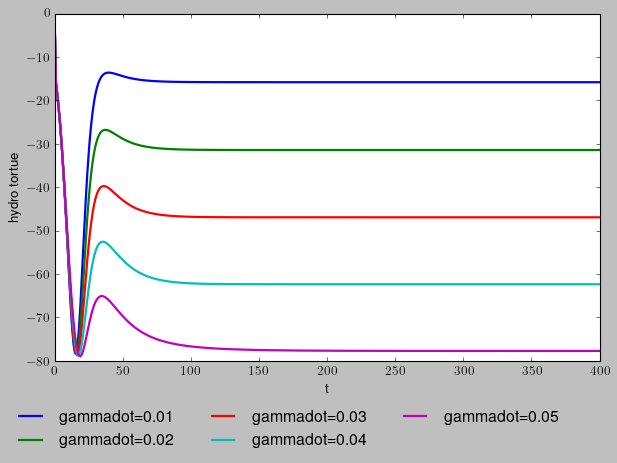

In [93]:
l = 0
k = 5
for hy, bh, g in zip(tr_hys[l:k], tr_bhs[l:k], gammadots[l:k]):
    plt.plot(hy, label=f'gammadot={g:0=0.2f}')
plt.xlabel("t")
plt.ylabel("hydro tortue")
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.1), loc='upper left')
plt.tight_layout()
# plt.subplots_adjust(top=0.8)
# plt.subplots_adjust(bottom=0.1)
plt.savefig('pics/tr_hy.png')

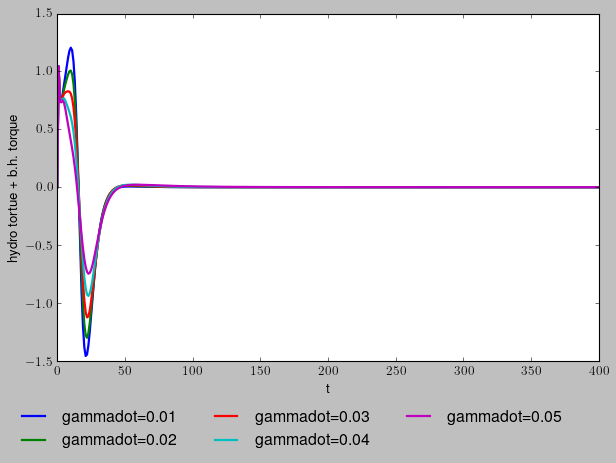

In [95]:
l = 0
k = 5
for hy, bh, g in zip(tr_hys[l:k], tr_bhs[l:k], gammadots[l:k]):
    plt.plot(hy + bh, label=f'gammadot={g:0=0.2f}')
plt.xlabel("t")
plt.ylabel("hydro tortue + b.h. torque")
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.1), loc='upper left')
plt.tight_layout()
# plt.subplots_adjust(top=0.8)
# plt.subplots_adjust(bottom=0.1)
plt.savefig('pics/tr_hy_bh.png')

In [151]:
gammadots = []

tr_hys    = []
tr_ss     = []
tr_bhs    = []

tr_css    = []
tr_cbhs   = []

for i in range(10):
    uobj = UDFManager(f'sim11/sim11-00/udf/{i:0=2}/output.udf')
    gammadot = uobj.get("constitutive_eq.Shear_Navier_Stokes.External_field.DC.Shear_rate")
    gammadots.append(gammadot)
    nt = uobj.totalRecord()
    
    tr_hy  = np.zeros(nt)  # from udf
    tr_s   = np.zeros(nt)  # from udf
    tr_bh  = np.zeros(nt)  # from udf

    tr_cs  = np.ones(nt) * (8 * np.pi * MU * (a**3) * 0.5 * gammadot) # calc
    tr_cbh = np.zeros(nt)
    for n in range(nt):
        uobj.jump(n)
        tr_hy[n] = (uobj.get("Particles[].torque_hydro")[0][-1])
        tr_s[n]  = (uobj.get("Particles[].torque_slip")[0][-1])
        tr_bh[n] = torques[i]['bh']
        
        q = Quaternion(*(uobj.get("Particles[].q"))[0])
        tr_cbh[n] = (np.cross(quaternionToRotationArray(q)[1], gravity) * h)[-1]

    tr_hys.append(tr_hy)
    tr_ss.append(tr_s)
    tr_bhs.append(tr_bh)

    tr_css.append(tr_cs)
    tr_cbhs.append(tr_cbh)
    mark = ' '
    if i==10:
        mark = 'o'
    print(f'{mark} shear: {gammadot: 2.4f}\t tr_hy: {tr_hy[-1]: 2.5f}\t tr_s: {tr_s[-1]: 2.5f}\t  sum: {tr_hy[-1]+tr_s[-1]: 2.5f}\t tr_bh: {tr_bh[-1]: 2.5f}\t cal_shear: {tr_cs[-1]: 2.5f}\t cal_bh: {tr_cbh[-1]: 2.5f}')

gammadots = np.array(gammadots)
n_gammadots = MU * (a**3) * 0.5 * gammadots * 8 * np.pi * 10

  shear:  0.0100	 tr_hy: -5.33260	 tr_s: -16.97845	  sum: -22.31104	 tr_bh:  22.63500	 cal_shear:  15.70796	 cal_bh:  22.31105
  shear:  0.0200	 tr_hy: -10.38311	 tr_s: -33.04503	  sum: -43.42814	 tr_bh:  43.95430	 cal_shear:  31.41593	 cal_bh:  43.42813
  shear:  0.0300	 tr_hy: -15.13820	 tr_s: -48.16799	  sum: -63.30620	 tr_bh:  48.41800	 cal_shear:  47.12389	 cal_bh:  63.30621
  shear:  0.0400	 tr_hy: -18.72733	 tr_s: -59.61313	  sum: -78.34047	 tr_bh:  52.69850	 cal_shear:  62.83185	 cal_bh:  78.33279
  shear:  0.0500	 tr_hy: -15.29399	 tr_s: -48.79776	  sum: -64.09175	 tr_bh:  56.68350	 cal_shear:  78.53982	 cal_bh:  63.61696
  shear:  0.0600	 tr_hy: -18.05337	 tr_s: -57.18000	  sum: -75.23337	 tr_bh:  60.72350	 cal_shear:  94.24778	 cal_bh:  74.97958
  shear:  0.0700	 tr_hy:  13.57009	 tr_s:  46.80283	  sum:  60.37292	 tr_bh:  62.81250	 cal_shear:  109.95574	 cal_bh: -58.65439
  shear:  0.0800	 tr_hy: -18.08278	 tr_s: -55.26379	  sum: -73.34657	 tr_bh:  65.10350	 cal_shear:  125.

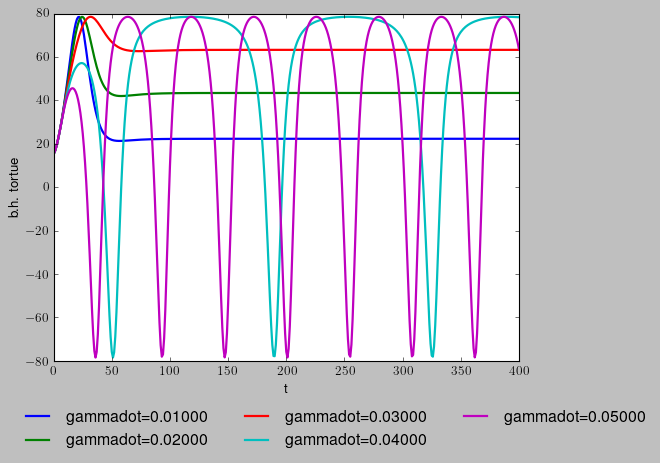

In [153]:
l = 0
k = 5
for bh, g in zip(tr_cbhs[l:k], gammadots[l:k]):
    plt.plot(bh, label=f'gammadot={g:0=0.5f}')
plt.xlabel("t")
plt.ylabel("b.h. tortue")
plt.legend(ncol=3, bbox_to_anchor=(-0.1, -0.1), loc='upper left')
plt.tight_layout()
# plt.subplots_adjust(top=0.8)
# plt.subplots_adjust(bottom=0.1)
# plt.savefig('tr_bh.png')